In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import torchtext.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import random
%matplotlib inline
%config Completer.use_jedi = False

```bash
bash ./preprocess.sh dump-tokenized
cat ~/data/tokenized/wiki_ko_mecab.txt ~/data/tokenized/ratings_mecab.txt ~/data/tokenized/korquad_mecab.txt > ~/data/tokenized/corpus_mecab.txt
```

<h1>2-1. Neural Probabilistic Language Model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Embedding-result" data-toc-modified-id="Embedding-result-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Embedding result</a></span></li></ul></div>

## Create dataset

* write each sample as a CSV file

In [2]:
n_gram = 3
corpus_path = os.path.join(os.getenv("HOME"), "data/tokenized/corpus_mecab.txt")
csv_path = os.path.join(os.getenv("HOME"), "data/csv/")
ngram_path = os.path.join(csv_path, f"{n_gram}gram_corpus_mecab.csv")

```python
import tqdm
import csv

with open(corpus_path) as r:
    if not os.path.isdir(csv_path):
        os.mkdir(csv_path)
    with open(ngram_path, "w", encoding='utf-8') as w:
        fieldnames = ['text', 'label']
        writer = csv.DictWriter(w, fieldnames=fieldnames)
        #writer.writeheader()
        
        for idx, sample in tqdm.tqdm(enumerate(r)):
            sentence = sample.split(" ")
            for i in range(len(sentence)-n_gram):
                text = " ".join(sentence[i:i+n_gram])
                target = sentence[i+n_gram]
                writer.writerow({"text": text, "label": target})
```

```bash
# `gsplit` if on macOS
split -d -l 1000000 ~/data/csv/3gram_corpus_mecab.csv ~/data/csv/3gram_corpus_mecab_ --additional-suffix=.csv
```

* build custom torchtext dataset with `torchtext.data.TabularDataset`.

In [3]:
TEXT = data.Field()
LABEL = data.Field()

/home/psh/.local/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [4]:
datafiles = [fname for fname in os.listdir(csv_path) if fname.startswith("3gram_corpus_mecab_")]

In [5]:
dataset = data.TabularDataset(
    os.path.join(csv_path, datafiles[0]), 
    format="csv",
    skip_header=True,
    fields=[
        ("text", TEXT),
        ("label", LABEL)
    ]
)

/home/psh/.local/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/psh/.local/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


* train only on small portion (for speed)

In [6]:
trainset, testset = dataset.split(0.1, random_state=random.seed(0))

In [7]:
trainset, validationset = trainset.split(0.9, random_state=random.seed(0))

* Build vocabulary

In [8]:
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(trainset, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(trainset)

* Now we build a `BucketIterator` for our model.

In [9]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
trainiter, validationiter, testiter = torchtext.data.BucketIterator.splits(
    (trainset, validationset, testset),
    batch_size=BATCH_SIZE,
    device=device
)

/home/psh/.local/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Build the model

![bengio et al.png](https://miro.medium.com/max/2408/1*EqKiy4-6tuLSoPP_kub33Q.png)

In [11]:
VOCAB_SIZE = len(TEXT.vocab)
N_GRAM = 3
EMBEDDING_DIM = 128
HIDDEN_DIM =  128

In [12]:
class NPLM(nn.Module):
    
    def __init__(self, vocab_size, n_gram, embedding_dim, hidden_dim):
        super(NPLM, self).__init__()
        self.vocab_size = vocab_size
        self.n_gram = n_gram
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # affine layers for tanh
        self.linear1 = nn.Linear(n_gram * embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size, bias=False)
        # affine layer for residual connection
        self.linear3 = nn.Linear(n_gram * embedding_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        #print(x.shape)
        
        x = x.view(-1, self.embedding_dim * self.n_gram)
        #print(x.shape)
        
        x1 = torch.tanh(self.linear1(x))
        x1 = self.linear2(x1)
        
        x2 = self.linear3(x)
        
        x = x1 + x2
        #print(x.shape)

        return x

## Train the model

* train the model

In [21]:
model = NPLM(VOCAB_SIZE, N_GRAM, EMBEDDING_DIM, HIDDEN_DIM)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model = model.to(device)
criterion = criterion.to(device)

In [23]:
def accuracy(pred, target):
    pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    correct = (pred == target).float()
    #print(pred.shape, correct.shape)
    return correct.sum() / len(correct)

In [35]:
def train(model, iterator, criterion, optimizer):
    loss_epoch = 0.
    acc_epoch = 0.
    for batch in trainiter:
        model.zero_grad()
        
        out = model(batch.text)
        #print("output:", out.shape)
        out = out.squeeze(0)
        #print("output (squeezed):", out.shape)
        
        target = batch.label.squeeze(0)
        #print("target:", target.shape)
        
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(out, target).item()
    return loss_epoch, acc_epoch

In [25]:
N_EPOCH = 200

losses = []
accs = []
for i in range(1, N_EPOCH+1):
    loss_epoch, acc_epoch = train(model, trainiter, criterion, optimizer)
    losses.append(loss_epoch)
    accs.append(acc_epoch)
    
    if i % 5 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(trainiter): .3f}, acc: {acc_epoch/len(trainiter): .4f}")

epoch: 005, loss:  7.120, acc:  0.0248
epoch: 010, loss:  7.074, acc:  0.0252
epoch: 015, loss:  7.050, acc:  0.0249
epoch: 020, loss:  7.037, acc:  0.0246
epoch: 025, loss:  7.027, acc:  0.0257
epoch: 030, loss:  7.018, acc:  0.0250
epoch: 035, loss:  7.013, acc:  0.0259
epoch: 040, loss:  7.006, acc:  0.0247
epoch: 045, loss:  7.002, acc:  0.0254
epoch: 050, loss:  6.998, acc:  0.0246
epoch: 055, loss:  6.993, acc:  0.0251
epoch: 060, loss:  6.990, acc:  0.0263
epoch: 065, loss:  6.984, acc:  0.0258
epoch: 070, loss:  6.985, acc:  0.0254
epoch: 075, loss:  6.978, acc:  0.0260
epoch: 080, loss:  6.979, acc:  0.0258
epoch: 085, loss:  6.975, acc:  0.0252
epoch: 090, loss:  6.973, acc:  0.0253
epoch: 095, loss:  6.971, acc:  0.0254
epoch: 100, loss:  6.969, acc:  0.0258
epoch: 105, loss:  6.967, acc:  0.0262
epoch: 110, loss:  6.965, acc:  0.0264
epoch: 115, loss:  6.963, acc:  0.0257
epoch: 120, loss:  6.962, acc:  0.0258
epoch: 125, loss:  6.958, acc:  0.0261
epoch: 130, loss:  6.960,

* save the intermediate model

In [26]:
torch.save(model.state_dict(), "./NPLM_SGD_lr0.01_momentum0.9_epoch200.pth")

## Embedding result

* load the pre-trained final model

In [38]:
model = NPLM(VOCAB_SIZE, N_GRAM, EMBEDDING_DIM, HIDDEN_DIM)
model.load_state_dict(torch.load("./NPLM_SGD_lr0.01+0.005+0.001_momentum0.9_epoch200+115+50.pth"))
model.eval()

NPLM(
  (embedding): Embedding(27115, 128)
  (linear1): Linear(in_features=384, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=27115, bias=False)
  (linear3): Linear(in_features=384, out_features=27115, bias=True)
)

In [39]:
embedding = model.embedding

* plot the embeddings

In [72]:
from sklearn.manifold import TSNE

In [115]:
test_words = TEXT.vocab.freqs.most_common(1000)
test_words_raw = [w for w, _ in test_words if len(w) > 1]
test_words = [TEXT.vocab.stoi[w] for w in test_words_raw]

In [116]:
with torch.no_grad():
    embed_xy = embedding(torch.tensor(test_words)).detach().numpy()
    embed_xy = TSNE(n_components=2).fit_transform(embed_xy)
    embed_x, embed_y = list(zip(*embed_xy))

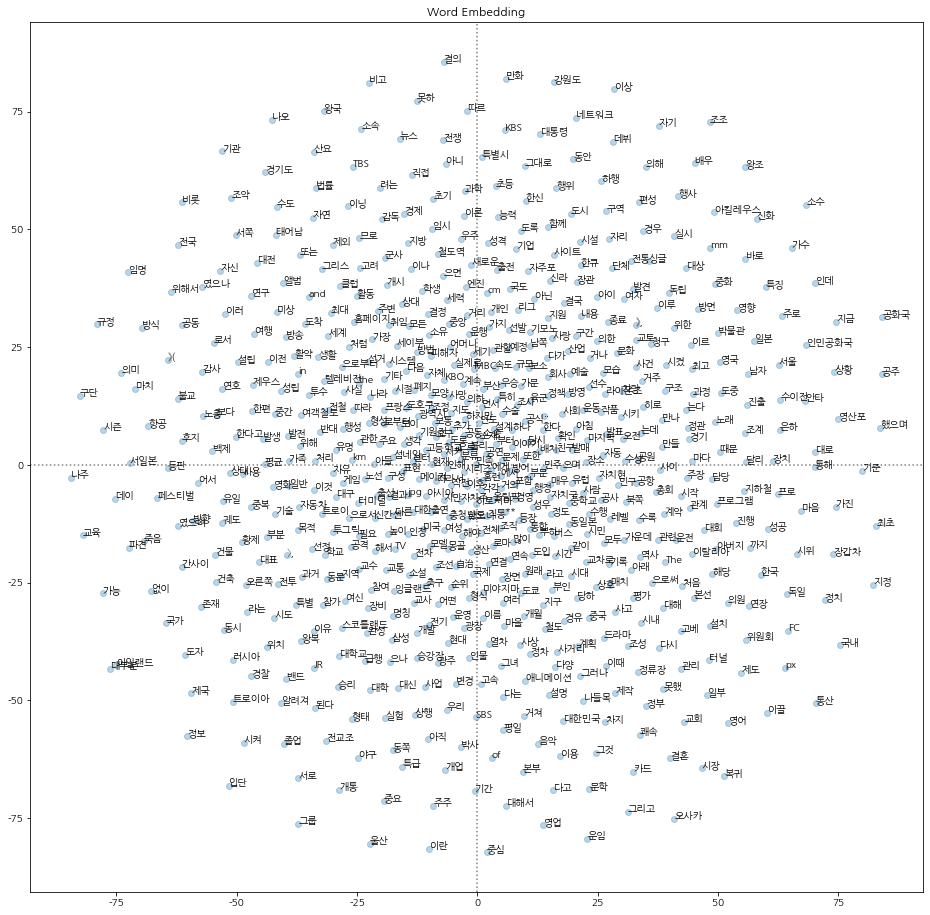

In [118]:
plt.figure(figsize=(16,16))

for xy, word in zip(embed_xy, test_words_raw):
    plt.annotate(word, xy, clip_on=True)

plt.title("Word Embedding")
plt.scatter(embed_x, embed_y, alpha=.3)
plt.axhline([0], ls=":", c="grey")
plt.axvline([0], ls=":", c="grey")